This notebook contains an attempt at modeling for our first run at clean training data.

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling function import
from model import modeling_reg2

# import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

# imports for classifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
# read in batter data
batters = pd.read_csv('../Modeling_Data/batter_data_modeling_iso.csv')

Testing across multiple regressors from sklearn to gage starting point.

In [3]:
# instaniate all models
linreg = LinearRegression()
knn = KNeighborsRegressor()
svc = SVR()
forest = RandomForestRegressor()
tree = DecisionTreeRegressor()
abc = AdaBoostRegressor()
bag = BaggingRegressor()

In [4]:
# create list of classifiers
class_list = [linreg, knn, svc, forest, tree, abc, bag]

In [5]:
# set X , y 
X = batters.drop(columns=['Name','Team','POS','FPPG', 'PTS'])
y = batters['FPPG']

In [6]:
#TTS 
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [7]:
# create results df using modeling fuction that fits and scores each model
results = modeling_reg(X_train, X_test, y_train, y_test, class_list)

In [8]:
# print results
results

,R2 Score - Train,R2 Score - Test,RMSE
LinearRegression(),0.930837,0.929186,0.802271
KNeighborsRegressor(),0.939031,0.861561,1.121732
SVR(),0.847869,0.868317,1.094022
RandomForestRegressor(),0.988508,0.903989,0.934159
DecisionTreeRegressor(),1.000000,0.803250,1.337266
AdaBoostRegressor(),0.927732,0.878565,1.050589
BaggingRegressor(),0.979306,0.897241,0.966430


Eventhough there is a testing data set for the initial modeling stage the training data was split using train_test_split.  This gives insight into the bias variance trade off to help in the modeling selection process.

In [9]:
batters['FPPG'].mean()

7.087898762039455

In [10]:
batters['Proj_FPPG'] = linreg.predict(X)

In [11]:
batters['Proj_FPPG'].mean()

7.086543923030149

Choosing linear regression from the modeling step above, because it has the lowest RMSE and balanced bias-variance trade off.  The means of the predictions and actual values provide insight into model performance as well.

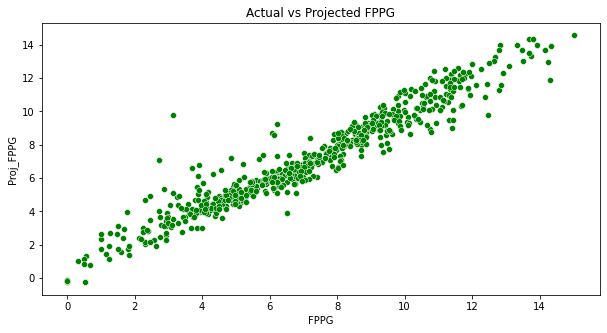

In [12]:
# plot prpjections against actuals
plt.figure(figsize=(10,5))
sns.scatterplot(x=batters['FPPG'], y=batters['Proj_FPPG'], color='green')
plt.title('Actual vs Projected FPPG');

Really good model how does it do on truely unseen data.

In [13]:
# read in clean testing data
batter_21 = pd.read_csv('../Modeling_Data/batter_test_data.csv')

In [16]:
# drop columns so as to same shape as X
testing = batter_21.drop(columns=['Name','Team','Pos','FPPG', 'PTS'])

In [17]:
# create projections for testing (2021) data based on model fit with train (2019-2020)
batter_21['Proj_FPPG'] = linreg.predict(testing)

In [18]:
# baseline mean of 2021 data
batter_21['FPPG'].mean()

7.006965259320823

In [19]:
batter_21['FPPG'].describe()

count    477.000000
mean       7.006965
std        3.961091
min        0.000000
25%        4.278571
50%        6.860000
75%        9.616667
max       40.900000
Name: FPPG, dtype: float64

In [20]:
# projected mean of 2021 data
batter_21['Proj_FPPG'].mean()

5.890568452579457

In [21]:
# RMSE
mean_squared_error(batter_21['FPPG'], batter_21['Proj_FPPG'], squared=False)

2.434089985629663

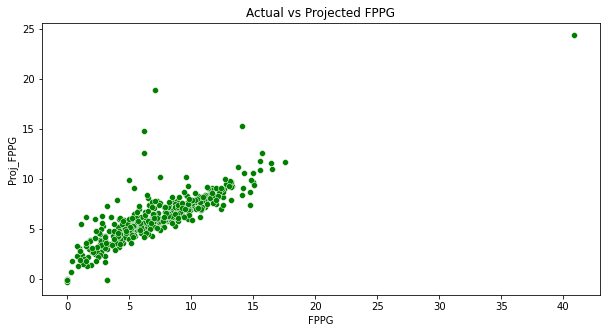

In [22]:
# plot prpjections against actuals testing data
plt.figure(figsize=(10,5))
sns.scatterplot(x=batter_21['FPPG'], y=batter_21['Proj_FPPG'], color='green')
plt.title('Actual vs Projected FPPG');

In [23]:
# check out outlier
batter_21.loc[batter_21['Proj_FPPG']>19]

,Name,Team,Pos,GMS,AB,R,H,2B,3B,HR,...,SB,CS,TB,AVG,OBP,SLG,OPS,PTS,FPPG,Proj_FPPG
376,Jacob Nottingham,MIL,C,1,4,2,2,0,0,2,...,0,0,8,0.5,0.5,2.0,2.5,40.9,40.9,24.338817


In [24]:
# save projections on test to csv
batter_21.to_csv('../Projections/batter_projections_2021.csv', index=False)

In [25]:
# dataframe of coefs
coef_df = pd.DataFrame(zip(X.columns, linreg.coef_), columns=['Feature', 'Coeficient'])
coef_df.sort_values(by='Coeficient', inplace=True)

In [26]:
coef_df

,Feature,Coeficient
13,AVG,-9.125083
0,GMS,-0.047045
12,TB,-0.014235
11,CS,-0.011568
4,2B,-0.005037
3,H,-0.002873
5,3B,-0.002534
8,BB,-0.000663
6,HR,-0.000419
9,SO,0.005453


Based on these coefficients I think we may need to scale the data to get all features on the same scale.  Then pull coefficient value to determine importance.

In [27]:
# scaling attempt
from sklearn.preprocessing import StandardScaler

In [28]:
sc = StandardScaler()

In [29]:
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [30]:
# run scaled data through modeling function
results = modeling_reg(X_train_sc, X_test_sc, y_train, y_test, class_list)

In [31]:
results

,R2 Score - Train,R2 Score - Test,RMSE
LinearRegression(),0.930837,0.929186,0.802271
KNeighborsRegressor(),0.919459,0.865278,1.106574
SVR(),0.941922,0.934053,0.774208
RandomForestRegressor(),0.988315,0.908901,0.909952
DecisionTreeRegressor(),1.000000,0.822417,1.270460
AdaBoostRegressor(),0.928733,0.884565,1.024305
BaggingRegressor(),0.983032,0.897251,0.966381


In [32]:
# dataframe of coefs
coef_df = pd.DataFrame(zip(X.columns, linreg.coef_), columns=['Feature', 'Coeficient'])
coef_df.sort_values(by='Coeficient', inplace=True)

In [33]:
coef_df

,Feature,Coeficient
0,GMS,-3.060533
3,H,-0.815436
12,TB,-0.613592
13,AVG,-0.572859
6,HR,-0.385775
4,2B,-0.205993
5,3B,-0.042803
11,CS,-0.025810
8,BB,-0.020317
10,SB,0.233839
